<a href="https://colab.research.google.com/github/Mkenza/Computer_V_SDI/blob/master/TP7_MAKHLOUF_Image_Caption_CNN_RNN_with__Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caption generation with visual attention

Caption generation is a challenging artificial intelligence problem where a textual description must be generated for a given photograph. The task of image captioning can be divided into two modules logically – one is an image based model – which extracts the features and nuances out of our image, and the other is a language based model – which translates the features and objects given by our image based model to a natural sentence.

A “classic” image captioning system would encode the image, using a pre-trained Convolutional Neural Network(ENCODER) that would produce a hidden state h.

Then, it would decode this hidden state by using a LSTM(DECODER) and generate recursively each word of the caption.
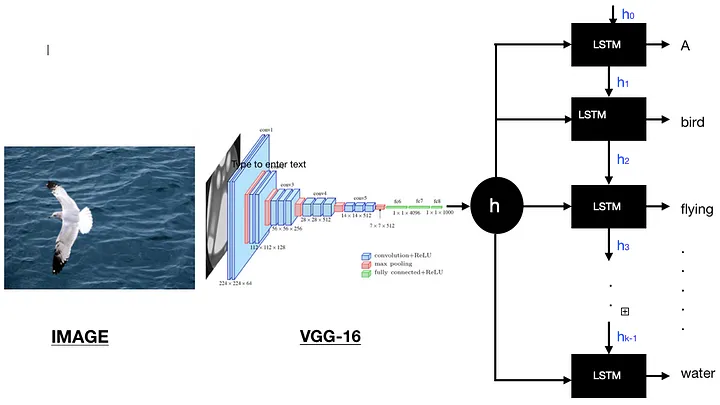

**Problem with ‘Classic’ Image Captioning Model**

The problem with this method is that, when the model is trying to generate the next word of the caption, this word is usually describing only a part of the image. It is unable to capture the essence of the entire input image. Using the whole representation of the image h to condition the generation of each word cannot efficiently produce different words for different parts of the image.This is exactly where an Attention mechanism is helpful.

# Attention-based Caption Generation

Given an image, our goal is to generate its caption. To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

The model architecture is similar to Show, Attend and Tell: Neural Image Caption Generation with Visual Attention.

This notebook is an end-to-end example. When you run the notebook, it downloads the MS-COCO dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

This notebook is an end-to-end example. When you run the notebook, it downloads Flickr8k datasett, preprocesses and caches a subset of images using VGG16 pretrained model, trains an encoder-decoder model, and generates captions on new images using the trained model.


## Download Flickr8k Dataset

Flilckr8K contains 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations.
*   Flickr8k_Dataset: Contains all the images
*   Flickr8k_text: Contains all the captions

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [ ]:
## The location of the Flickr8K_ photos
dir_Flickr_jpg = "Flicker8k_Dataset"
## The location of the caption file
dir_Flickr_text = "Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.applications.imagenet_utils import preprocess_input

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import json
from glob import glob
from PIL import Image
import pickle

import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 

## Exploring the Data

Import caption data

Load the text data and save it into a panda dataframe data.

* filename : jpg file name
* index : unique ID for each caption for the same image
* caption : string of caption, all in lower case

In [ ]:
## read in the Flickr caption data
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(data.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(data.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

In [ ]:
data.head(10)

Let's have a look at some of the pictures together with the captions.
You can obseve:
* For each image there are 5 distinct captions
* Some sentences finish with "." but not all.

In [ ]:
#from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = tf.keras.utils.load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

#  Preprocessing




### Images

Let's check if there are any unvalid image!

In [ ]:
#https://www.mkyong.com/regular-expressions/how-to-validate-image-file-extension-with-regular-expression/
import re
for i in data["filename"]:
    x = re.search("([^\s]+(\.(?i)(jpg|png|gif|bmp))$)", i)
    if (x):
        pass
    else:
        print(f"YES! We have a match!: {i}")

YES! We have a match!: 2258277193_586949ec62.jpg.1
YES! We have a match!: 2258277193_586949ec62.jpg.1
YES! We have a match!: 2258277193_586949ec62.jpg.1
YES! We have a match!: 2258277193_586949ec62.jpg.1
YES! We have a match!: 2258277193_586949ec62.jpg.1


<ipython-input-16-f8b16fedc265>:4: DeprecationWarning: Flags not at the start of the expression '([^\\s]+(\\.(?i)(jpg|p' (truncated)
  x = re.search("([^\s]+(\.(?i)(jpg|png|gif|bmp))$)", i)


In [ ]:
data.shape

(40460, 3)

In [ ]:
data.loc[data['filename'] == "2258277193_586949ec62.jpg.1"]

,filename,index,caption
6730,2258277193_586949ec62.jpg.1,0,people waiting for the subway
6731,2258277193_586949ec62.jpg.1,1,some people looking out windows in a large bui...
6732,2258277193_586949ec62.jpg.1,2,three people are waiting on a train platform .
6733,2258277193_586949ec62.jpg.1,3,three people standing at a station .
6734,2258277193_586949ec62.jpg.1,4,two woman and one man standing near train trac...


In [ ]:
data = data[data.filename != '2258277193_586949ec62.jpg.1']

In [ ]:
data.shape

(40455, 3)

### Captions

In [ ]:
def df_word(data):
    vocabulary = []
    for txt in data.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(data)

Vocabulary Size: 8918


In [ ]:
dfword.head(10)

,word,count
0,a,62986
1,.,36577
2,in,18974
3,the,18418
4,on,10743
5,is,9345
6,and,8851
7,dog,8136
8,with,7765
9,man,7265


In [ ]:
dfword.tail(10)

,word,count
8908,lace-up,1
8909,blasted,1
8910,graying,1
8911,wallride,1
8912,banister,1
8913,backflips,1
8914,bikina,1
8915,saroog,1
8916,sarongs,1
8917,patterns,1


In [ ]:
data.caption.values

array(['a child in a pink dress is climbing up a set of stairs in an entry way .',
       'a girl going into a wooden building .',
       'a little girl climbing into a wooden playhouse .', ...,
       'a person in a red shirt climbing up a rock face covered in assist handles .',
       'a rock climber in a red shirt .',
       'a rock climber practices on a rock climbing wall .'], dtype=object)

In [ ]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))
ct = Counter(vocabulary)
ct.keys()

## The most and least frequently appearing words
The most common words are articles such as "a", or "the", or punctuations.

These words do not have much infomation about the data.

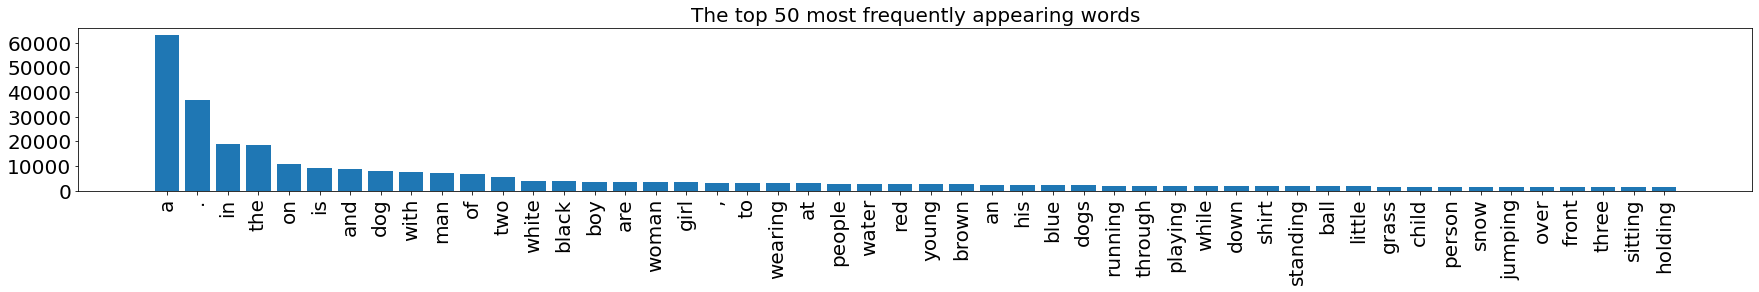

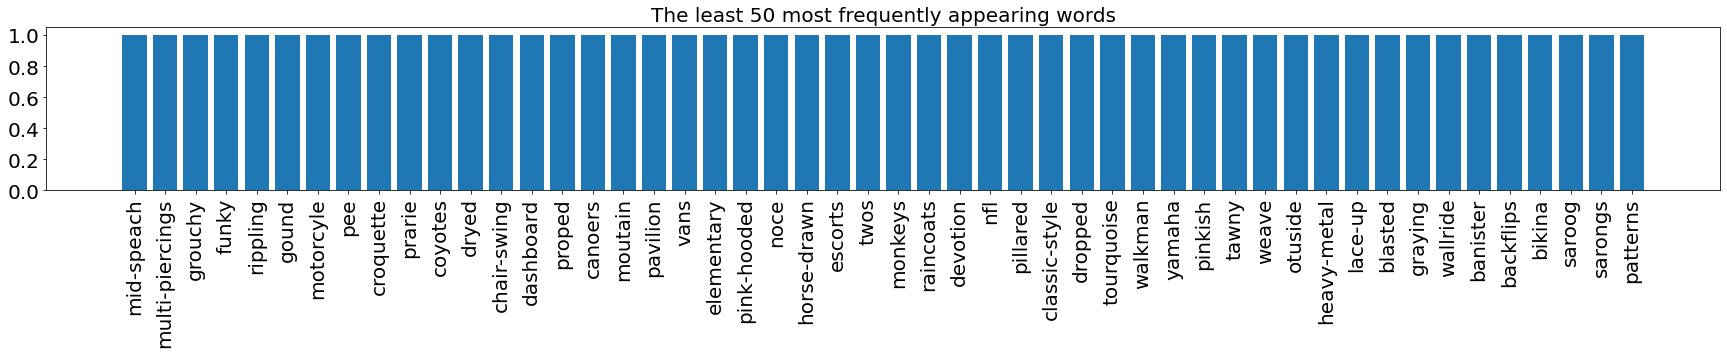

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(30,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

Check Image shape:

Shape of the image: (500, 375, 3)


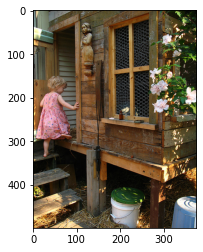

In [ ]:
img1= plt.imread("Flicker8k_Dataset/1000268201_693b08cb0e.jpg")
plt.imshow(img1)
print(f"Shape of the image: {img1.shape}")

In [ ]:
#make a list of images and caption
img = data["filename"].tolist()
caption = data["caption"].tolist()

In [ ]:
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

len(img) : 40455
len(caption) : 40455


In [ ]:
#Distinct images an Captions
print(f"Total Unique imgs : {len(set(img))}")
print(f"total unique captions : {len(set(caption))}")

Total Unique imgs : 8091
total unique captions : 40170


In [ ]:
data.head()

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...


## Add start and end sequence tokens

Usually, a pretrained CNN extracts the features from our input image. The feature vector is linearly transformed to have the same dimension as the input dimension of the RNN (LSTM, GRU; ...) network. This network is trained as a language model on our feature vector.

For training our RNN model, we predefine our label and target text. For example, if the caption is “A man and a girl sit on the ground and eat.”, our label and target would be as follows –

Label – [<start<start>>, A,  man,  and,  a, girl,  sit,  on,  the,  ground,  and,  eat,  <end<start>> ] 
    
Target – [ A, man,  and,  a,  girl,  sit,  on,  the,  ground,  and,  eat,  ., <<end>> ]

This is done so that our model understands the start and end of our labelled sequence.

In [ ]:
#Add start and end sequence tokens
PATH = "Flicker8k_Dataset/"
all_captions = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:10]

['<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a girl going into a wooden building . <end>',
 '<start> a little girl climbing into a wooden playhouse . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>',
 '<start> a little girl in a pink dress going into a wooden cabin . <end>',
 '<start> a black dog and a spotted dog are fighting <end>',
 '<start> a black dog and a tri-colored dog playing with each other on the road . <end>',
 '<start> a black dog and a white dog with brown spots are staring at each other in the street . <end>',
 '<start> two dogs of different breeds looking at each other on the road . <end>',
 '<start> two dogs on pavement moving toward each other . <end>']

In [ ]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = PATH + annot

    all_img_name_vector.append(full_image_path)
all_img_name_vector[:10]

['Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


## limitting the size of the training set 
We'll use a subset of 40,000 captions and their corresponding images to train our model.

In [ ]:
# Shuffle captions and image_names together
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

In [ ]:
# Select the first 40000 captions from the shuffled set
num_examples = 40000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
print(f"priviously we had {len(all_captions)} captions, and Now we have {len(train_captions)}.")

priviously we had 40455 captions, and Now we have 40000.


## Preprocess the images using VGG16
Next, we will use VGG16 (which is pretrained on Imagenet) to classify each image. Create features for each image using VGG16's pre-trained networks.
We will extract features from the last convolutional layer.

First, we will convert the images into VGG16's expected format by:
* Resizing the image to 224*224px

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
import tensorflow as tf
modelvgg = tf.keras.applications.VGG16

In [ ]:

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

## Initialize VGG16 and load the pretrained Imagenet weights


* As we are not using VGG16 for the sake of the classification but we just need it for extracting features, we will remove the last layer from the network.
* We forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).

In [ ]:
image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
modelvgg = tf.keras.applications.VGG16(include_top=True,weights=None) # for observation on shapes
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Features extractraction from VGG16

 


In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

print(f"Let's check the BatchDataset shapes--> {image_dataset}")

Let's check the BatchDataset shapes--> <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [ ]:
from tqdm import tqdm
%%time
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [01:22<00:00,  1.55it/s]

CPU times: user 1min 32s, sys: 3.35 s, total: 1min 36s
Wall time: 1min 22s


In [ ]:
bf.numpy().shape

(49, 512)

In [ ]:
print(batch_features.numpy().shape)

(27, 49, 512)


## Preprocess and tokenize the captions

* First, we'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, we'll limit the vocabulary size to the top 5,000 words (to save memory)
* You then create word-to-index and index-to-word mappings.
* Finally, we pad all sequences to be the same length as the longest one.

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)


tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


print(cap_vector.shape)

(40000, 39)


## Split the data into training and testing

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)


# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

**Create a tf.data dataset for training**

Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.



In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 512
attention_features_shape = 49

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap


dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Model

* In this example, you extract the features from the lower convolutional layer of VGG16 giving us a vector of shape (224, 224, 3).
* Then squash that to a shape of (64, 512).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
encoder.summary()

Model: "cnn__encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  131328    
                                                                 
Total params: 131,328
Trainable params: 131,328
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder.summary()

Model: "rnn__decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2166272   
                                                                 
 gru (GRU)                   multiple                  1575936   
                                                                 
 dense_1 (Dense)             multiple                  262656    
                                                                 
 dense_2 (Dense)             multiple                  4341006   
                                                                 
 bahdanau_attention (Bahdana  multiple                 394753    
 uAttention)                                                     
                                                                 
Total params: 8,740,623
Trainable params: 8,740,623
Non-trainable params: 0
____________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint


In [ ]:
checkpoint_path_ckpt = "./checkpoint_final/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## Training

* Now we extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
> Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.
Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

  return loss, total_loss

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

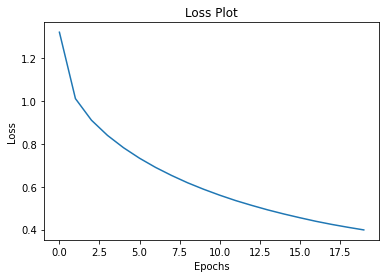

In [ ]:

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## captions on the validation set

Real Caption: <start> a group of people are walking down a sidewalk beside the beach <end>
Prediction Caption: people walking down a road <end>


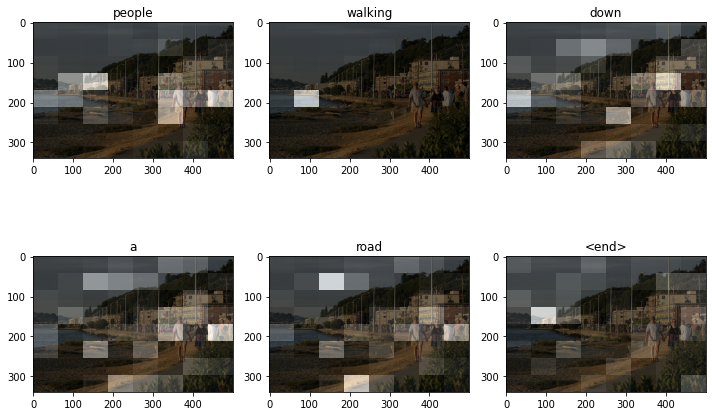

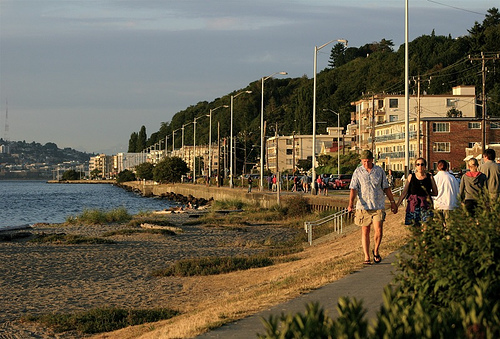

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

for i in result:
    if i=="<unk>":
        result.remove(i)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

# Try it on your own images

40960/37840 [================================] - 0s 4us/step
Prediction Caption: a beige dog is running on grass <end>


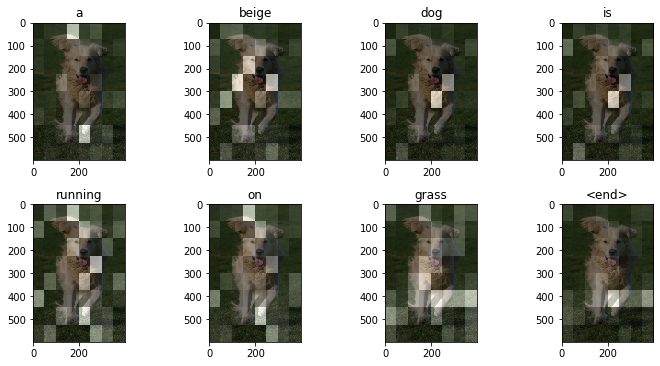

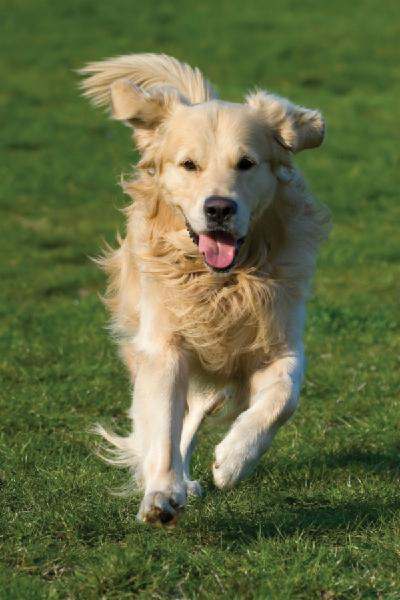

In [ ]:
image_url = 'http://www.bhamgov.org/DPS/Dog_Running.jpg'
image_extension = image_url[-3:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

**BLEU score**

You can evaluate the sentence prediction using Bilingual evaluation understudy (BLEU) score

BELU score: 22.360679774997898
Real Caption: a girl is holding a paint brush in a plastic cup and painting the ground
Prediction Caption: a person paints the ground white outside


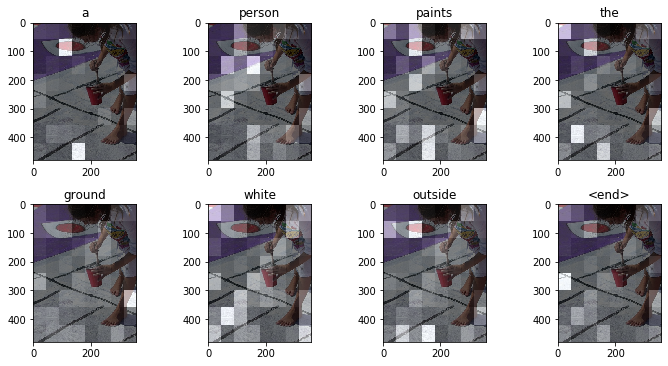

time took to Predict: 1 sec


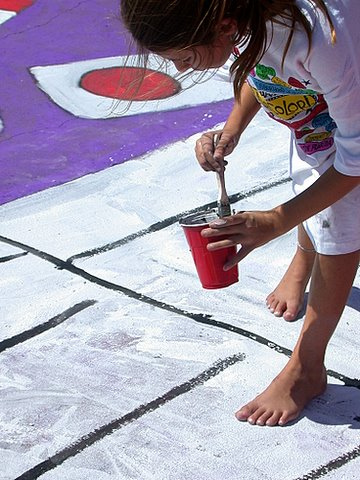

In [ ]:
# captions on the validation set


# longer candidate
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_val[rid])

Real Caption: a young boy does a one <unk> handstand on a concrete
Prediction Caption: a boy is doing a handstand


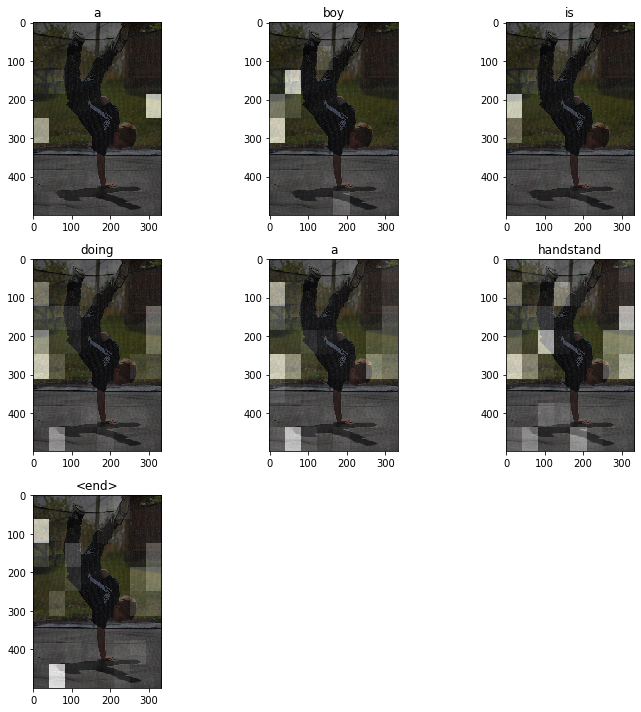

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result
score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")


print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)


# opening the image
IMG(img_name_val[rid])

tts = gTTS(result_final) #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True) 


**Exercice 1**: What you propose to improve the caption prediction?

**Exercice 2**: Insted of VGG16 for CNN features, try with another pretrained model (InceptionV3) and instead of GRU (RNN features) try with LSTM.

**Exercice 3**: Modify your approach to have a classic image captioning model (only Encoder and Decoder without attention)